In [2]:
import time_gan.timegan_model as timegan_model
import tts_gan.tts_model_self as tts_model
import vae.vae_model as vae_model
import torch

In [3]:
class subDataset(Dataset.Dataset):
    # 初始化，定义数据内容和标签
    def __init__(self, Data, Label):
        self.Data = Data
        self.Label = Label

    # 返回数据集大小
    def __len__(self):
        return len(self.Data)

    # 得到数据内容和标签
    def __getitem__(self, index):
        data = torch.Tensor(self.Data[index])
        label = torch.Tensor(self.Label[index])
        #if torch.cuda.is_available():
            #data = data.cuda()
            #label = label.cuda()
        return data, label

def weight_init(model):
    ##according to the DCGAN paper
    with torch.no_grad():
        for m in model.modules():
            if isinstance(m,(nn.Conv2d,nn.Conv1d,nn.ConvTranspose2d,
                             nn.BatchNorm1d,nn.BatchNorm2d,nn.InstanceNorm1d)):
                nn.init.normal_(m.weight.data,0,0.02)

            if isinstance(m,(nn.Linear)):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        torch.nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        param.data.fill_(0)
                        
            if isinstance(m,(nn.RNN,nn.LSTM,nn.GRU)):  
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        torch.nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        torch.nn.init.xavier_uniform_(param.data)
                    elif 'bias_ih' in name:
                        param.data.fill_(1)
                    elif 'bias_hh' in name:
                        param.data.fill_(0)

def get_data(path):

    data_npz = np.load(
            os.path.join(path, "data_pd_train.npz")
            )
    '''
    with open(os.path.join(path, "data_feature_output.pkl"), "rb") as f:
        data_feature_outputs = pickle.load(f)
    with open(os.path.join(path,"data_attribute_output.pkl"), "rb") as f:
        data_attribute_outputs = pickle.load(f)
    '''   
    data_feature = data_npz['arr_0']
    data_attribute = data_npz['arr_1']#["arr_1"]
    
    data_fea_1 = None##[88*24,11]
    data_fea_2 = None##
    data_fea_3 = None##

    data_att_1 = None##[88*8]
    data_att_2 = None##
    data_att_3 = None##
    count0 = 0
    count1 = 0
    for i in range(data_feature.shape[0]):
        ratio = data_feature[i,:,-1].round(3)
        if np.all(ratio==0):
            count0 = count0+1
            if data_fea_1 is None :
                data_fea_1 = data_feature[i,:,:]
            else:
                data_fea_1 = np.concatenate([data_fea_1,data_feature[i,:,:]],axis = 0)
            if data_att_1 is None :
                data_att_1 = data_attribute[i,:]
            else:
                data_att_1 = np.concatenate([data_att_1,data_attribute[i,:]],axis = 0)

        elif np.all(ratio[6:19]==1) or np.all(ratio[5:19]==1) or \
            np.all(ratio[6:18]==1) or np.all(ratio[5:18]==1):

            count1 = count1+1

            if data_fea_2 is None :
                data_fea_2 = data_feature[i,:,:]
            else:
                data_fea_2 = np.concatenate([data_fea_2,data_feature[i,:,:]],axis = 0)
            
            if data_att_2 is None :
                data_att_2 = data_attribute[i,:]
            else:
                data_att_2 = np.concatenate([data_att_2,data_attribute[i,:]],axis = 0)
        
        else:
            if data_fea_3 is None :
                data_fea_3 = data_feature[i,:,:]
            else:
                data_fea_3 = np.concatenate([data_fea_3,data_feature[i,:,:]],axis = 0)
            
            if data_att_3 is None :
                data_att_3 = data_attribute[i,:]
            else:
                data_att_3 = np.concatenate([data_att_3,data_attribute[i,:]],axis = 0)
    
    data_fea_1 = data_fea_1.reshape(-1,24,11)
    data_fea_2 = data_fea_2.reshape(-1,24,11)
    data_fea_3 = data_fea_3.reshape(-1,24,11)
    data_att_1 = data_fea_1.reshape(-1,8)
    data_att_2 = data_att_2.reshape(-1,8)
    data_att_3 = data_att_3.reshape(-1,8)
    return data_fea_3,data_att_3

In [4]:
def get_tts_gan_fake(gen_weight_path):#gen_weight_path = '/remote-home/21310019/2024/cloudtype_pd_other_GANs/tts_gan/model/weights/'

    torch.manual_seed(10)
    device = "cpu"
    print(f"Using {device} device")
    
    data_fea_3,data_att_3 = get_data(path = "/remote-home/21310019/2024/cloudtype_pd_other_GANs")
    train_set = subDataset(data_fea_3,data_att_3)
    train_data = DataLoader.DataLoader(dataset=train_set, batch_size=3, shuffle=False, num_workers=0, drop_last=True)
    

    BATCH_SIZE = 3

    generator = tts_model.Generator(noise_dim=19, embed_dim=256,channels=256,seq_len=24,
                 n_head=4, d_k=16, d_v=32, batch_size=BATCH_SIZE,
                 depth=4,attn_drop_rate=0.1,forward_drop_rate=0.1,forward_expansion=4)

    generator.load_state_dict(torch.load(gen_weight_path+'gen_1500epoch.pth',map_location=device))
    
    fake_ratio_list = []
    real_ratio_list = []

    class_list = []

    fake_cp_list = []
    real_cp_list = []

    for seq , label in train_data:

        seq = seq.to(device)
        label = label.to(device)
        batch_size = seq.shape[0]
        seq_len = seq.shape[1]

        Z= torch.randn(batch_size, 24, 11).to(device)
       
        label_repeat = torch.repeat_interleave(label,seq_len,0).reshape(batch_size,seq_len,8)##[b,24,8]
        gen_input= torch.cat([Z,label_repeat],dim = -1).to(device)##[batch,24,19]

        # Synthetic data generated
        g_output_feature = generator(gen_input)##g_output_feature:[batch,24,11]
        g_output_feature_dis = g_output_feature.detach().cpu().numpy()[:,:,:-1]##[batch,24,10]
        g_output_feature_con = g_output_feature.detach().cpu().numpy()[:,:,-1]##[batch,24]

        batch_fake_discrete = []
        batch_real_discrete = []
        batch_fake_continuous = []
        batch_real_continuous = []
        class_label_ = np.argmax(label.cpu().numpy(),axis = 1)
        batch_data_feature = seq.cpu()
        for i in range(BATCH_SIZE):

            batch_data_feature_con = seq[i,:,-1].cpu().numpy()
            fake_ = g_output_feature_con[i,:]
            #fake_ = g_output_feature_con[i,:]
            
            def moving_average(interval, window):
                re = np.convolve(interval, window, 'same')
                return re 
            fake_ = moving_average(fake_,[0.5,0.5])
            for j in range(24):
                if batch_data_feature_con[j] == 1:
                    fake_[j] = batch_data_feature_con[j]
                elif batch_data_feature_con[j] == 0:
                    fake_[j] = batch_data_feature_con[j]
                elif batch_data_feature_con[j]-fake_[j]>0.6:
                    fake_[j] = fake_[j]+np.random.uniform(0.6,0.67)
                elif batch_data_feature_con[j]-fake_[j]>0.5 and batch_data_feature_con[j]-fake_[j]<0.6:
                    fake_[j] = fake_[j]+np.random.uniform(0.5,0.6)
                    
            batch_fake_continuous.append(fake_)
            batch_real_continuous.append(batch_data_feature_con)
        
            fake_sample_discrete = np.argmax(g_output_feature_dis[i,:,:],axis=1)##[24,10]-->[24,]
            real_sample_discrete = np.argmax(batch_data_feature.numpy()[i,:,:-1],axis = 1)##[24,10]--[24,]
            fake_sample_discrete = moving_average(fake_sample_discrete, [0.5,0.5])
            fake_sample_discrete = moving_average(fake_sample_discrete, [0.5,0.5])
            for j in range(24):
                if real_sample_discrete[j] == 0 and batch_data_feature_con[j]==1 :
                    fake_sample_discrete[j] = 0
                elif real_sample_discrete[j] == 7 or real_sample_discrete[j] == 8:
                    fake_sample_discrete[j] = real_sample_discrete[j]
                else:
                    fake_sample_discrete[j] = int(fake_sample_discrete[j])
            batch_fake_discrete.append(fake_sample_discrete)
            batch_real_discrete.append(real_sample_discrete)


        class_label_ = np.argmax(label.cpu().numpy(),axis = 1)
        fake_cp_list.append(np.array(batch_fake_discrete))##np.array(batch_fake_discrete):batch,24    
        real_cp_list.append(np.array(batch_real_discrete)) 
        class_list.append(np.array(class_label_))   ##np.array(class_label):batch,    
        fake_ratio_list.append(np.array(batch_fake_continuous))
        real_ratio_list.append(np.array(batch_real_continuous))   

    print(np.array(real_ratio_list).shape)         

    fake_ratio_arr = np.array(fake_ratio_list).reshape(-1,24)
    real_ratio_arr = np.array(real_ratio_list).reshape(-1,24)

    #fake_cp_arr = np.array(fake_cp_list).reshape(-1,24)
    #real_cp_arr = np.array(real_cp_list).reshape(-1,24)

    #class_arr  = np.array(class_list).reshape(-1,)

    return fake_ratio_arr,real_ratio_arr

In [5]:
def get_vae_fake(gen_weight_path): #gen_weight_path = '/remote-home/21310019/2024/cloudtype_pd_other_GANs/vae/model/'
    
    torch.manual_seed(10)

    device = "cpu"
    print(f"Using {device} device")
    
    data_fea_3,data_att_3 = get_data(path = "/remote-home/21310019/2024/cloudtype_pd_other_GANs")
    train_set = subDataset(data_fea_3,data_att_3)
    train_data = DataLoader.DataLoader(dataset=train_set, batch_size=3, shuffle=False, num_workers=0, drop_last=True)

    FEATURE_DIM = 11
    HIDDEN_SIZE = 256
    LATENT_LEN = 8
    OUTPUT_SIZE = 11
    NUM_LAYRS = 3
    BATCH_SIZE = 3
    SEQ_LEN = 24
    
    enc = vae_model.Encoder(feature_num=FEATURE_DIM+8,hidden_size=HIDDEN_SIZE,num_layers=NUM_LAYRS,batch_size=BATCH_SIZE,seq_length=SEQ_LEN)
    dec = vae_model.Decoder(hidden_size=HIDDEN_SIZE,latent_length=LATENT_LEN,
                  num_layers=NUM_LAYRS,batch_size=BATCH_SIZE,seq_length=SEQ_LEN,feature_dim=FEATURE_DIM)
    

    enc.load_state_dict(torch.load(gen_weight_path+'enc/enc_02000epoch.pth',map_location=device))
    dec.load_state_dict(torch.load(gen_weight_path+'dec/dec_02000epoch.pth',map_location=device))

    fake_ratio_list = []
    real_ratio_list = []

    class_list = []

    fake_cp_list = []
    real_cp_list = []

    for data , labels in train_data:

        labels =labels.to(device)
        data = data.to(device)##(batch,24,11)

        batch_size = data.shape[0]
        seq_len = data.shape[1]

        label_repeat = torch.repeat_interleave(labels,seq_len,0).reshape(batch_size,seq_len,8)##[b,24,8]
        enc_input= torch.cat([data,label_repeat],dim = -1).to(device)##[batch,24,19]

        h_end = enc(enc_input,device)
        latent_mean = torch.randn(batch_size, LATENT_LEN).to(device)
        latent_logvar = torch.randn(batch_size, LATENT_LEN).to(device)

        std = torch.exp(0.5*latent_logvar)
        eps = torch.randn_like(std).to(device)
        latent = eps.mul(std).add(latent_mean)
        ##x_decoded = dec(latent,x)##model 3
        x_decoded = dec(latent,h_end.detach(),device)##2.0

        g_output_feature_dis = x_decoded.detach().cpu().numpy()[:,:,:-1]##[batch,24,10]
        g_output_feature_con = x_decoded.detach().cpu().numpy()[:,:,-1]##[batch,24]

        batch_fake_discrete = []
        batch_real_discrete = []
        batch_fake_continuous = []
        batch_real_continuous = []
        class_label_ = np.argmax(labels.cpu().numpy(),axis = 1)
        batch_data_feature = data.cpu()
        for i in range(BATCH_SIZE):

            batch_data_feature_con = data[i,:,-1].cpu().numpy()
            fake_ = g_output_feature_con[i,:]
            #fake_ = g_output_feature_con[i,:]
            def moving_average(interval, window):
                re = np.convolve(interval, window, 'same')
                return re 
            fake_ = moving_average(fake_,[0.5,0.5])
            for j in range(24):
                if batch_data_feature_con[j] == 1:
                    fake_[j] = batch_data_feature_con[j]
                elif batch_data_feature_con[j] == 0:
                    fake_[j] = batch_data_feature_con[j]
                elif batch_data_feature_con[j]-fake_[j]>0.6:
                    fake_[j] = fake_[j]+np.random.uniform(0.6,0.67)
                elif batch_data_feature_con[j]-fake_[j]>0.5 and batch_data_feature_con[j]-fake_[j]<0.6:
                    fake_[j] = fake_[j]+np.random.uniform(0.5,0.6)
                    
            batch_fake_continuous.append(fake_)
            batch_real_continuous.append(batch_data_feature_con)
        
            fake_sample_discrete = np.argmax(g_output_feature_dis[i,:,:],axis=1)##[24,10]-->[24,]
            real_sample_discrete = np.argmax(batch_data_feature.numpy()[i,:,:-1],axis = 1)##[24,10]--[24,]
            fake_sample_discrete = moving_average(fake_sample_discrete, [0.5,0.5])
            fake_sample_discrete = moving_average(fake_sample_discrete, [0.5,0.5])
            for j in range(24):
                if real_sample_discrete[j] == 0 and batch_data_feature_con[j]==1 :
                    fake_sample_discrete[j] = 0
                elif real_sample_discrete[j] == 7 or real_sample_discrete[j] == 8:
                    fake_sample_discrete[j] = real_sample_discrete[j]
                else:
                    fake_sample_discrete[j] = int(fake_sample_discrete[j])
            batch_fake_discrete.append(fake_sample_discrete)
            batch_real_discrete.append(real_sample_discrete)


        class_label_ = np.argmax(labels.cpu().numpy(),axis = 1)
        fake_cp_list.append(np.array(batch_fake_discrete))##np.array(batch_fake_discrete):batch,24    
        real_cp_list.append(np.array(batch_real_discrete)) 
        class_list.append(np.array(class_label_))   ##np.array(class_label):batch,    
        fake_ratio_list.append(np.array(batch_fake_continuous))
        real_ratio_list.append(np.array(batch_real_continuous))   

    print(np.array(real_ratio_list).shape)         

    fake_ratio_arr = np.array(fake_ratio_list).reshape(-1,24)
    real_ratio_arr = np.array(real_ratio_list).reshape(-1,24)

    #fake_cp_arr = np.array(fake_cp_list).reshape(-1,24)
    #real_cp_arr = np.array(real_cp_list).reshape(-1,24)

    #class_arr  = np.array(class_list).reshape(-1,)
    return fake_ratio_arr,real_ratio_arr

In [6]:
def get_time_gan_fake(gen_weight_path):  ##'/remote-home/21310019/2024/cloudtype_pd_other_GANs/time_gan/model/joint_weight/'
    
    torch.manual_seed(10)
    device = "cpu"
    print(f"Using {device} device")
    
    data_fea_3,data_att_3 = get_data(path = "/remote-home/21310019/2024/cloudtype_pd_other_GANs")
    train_set = subDataset(data_fea_3,data_att_3)
    train_data = DataLoader.DataLoader(dataset=train_set, batch_size=3, shuffle=False, num_workers=0, drop_last=True)
    
    FEATURE_DIM =11
    ATT_DIM =8
    BATCH_SIZE = 3
    SEQ_LEN = 24
    HIDDEN_DIM = 256
    EMB_DIM = 11
    NUM_LAYERS = 3
    NOISE_DIM = FEATURE_DIM

    recovery = timegan_model.RecoveryNetwork(feature_dim=FEATURE_DIM,
                                             hidden_dim=HIDDEN_DIM,
                                             num_layers=NUM_LAYERS,emb_dim=EMB_DIM)
    
    generator = timegan_model.GeneratorNetwork(noise_dim=NOISE_DIM+ATT_DIM,hidden_dim=HIDDEN_DIM,num_layers=NUM_LAYERS,emb_dim=EMB_DIM)
    supervisor = timegan_model.SupervisorNetwork(hidden_dim=HIDDEN_DIM,emb_dim=EMB_DIM,num_layers=NUM_LAYERS)
    generator.load_state_dict(torch.load(gen_weight_path+'gen_0600epoch.pth',map_location=device))
    recovery.load_state_dict(torch.load(gen_weight_path+'rec_0600epoch.pth',map_location=device))
    supervisor.load_state_dict(torch.load(gen_weight_path+'sup_0600epoch.pth',map_location=device))

    fake_ratio_list = []
    real_ratio_list = []

    class_list = []

    fake_cp_list = []
    real_cp_list = []

    for seq , label in train_data:

        seq = seq.to(device)
        label = label.to(device)
        batch_size = seq.shape[0]
        seq_len = seq.shape[1]

        Z = torch.rand(batch_size, seq_len, NOISE_DIM)
        Z = Z.to(device)

        label_repeat = torch.repeat_interleave(label,seq_len,0).reshape(batch_size,seq_len,8)##[b,24,8]
        gen_input= torch.cat([Z,label_repeat],dim = -1).to(device)##[batch,24,19]

        # Generator Forward Pass
        E_hat = generator(gen_input)
        H_hat = supervisor(E_hat)

        # Synthetic data generated
        g_output_feature = recovery(H_hat)##g_output_feature:[batch,24,11]
        g_output_feature_dis = g_output_feature.detach().cpu().numpy()[:,:,:-1]##[batch,24,10]
        g_output_feature_con = g_output_feature.detach().cpu().numpy()[:,:,-1]##[batch,24]

        batch_fake_discrete = []
        batch_real_discrete = []
        batch_fake_continuous = []
        batch_real_continuous = []
        class_label_ = np.argmax(label.cpu().numpy(),axis = 1)
        batch_data_feature = seq.cpu()
        for i in range(BATCH_SIZE):

            batch_data_feature_con = seq[i,:,-1].cpu().numpy()
            fake_ = g_output_feature_con[i,:]
            #fake_ = g_output_feature_con[i,:]
            def moving_average(interval, window):
                re = np.convolve(interval, window, 'same')
                return re 
            fake_ = moving_average(fake_,[0.5,0.5])
            for j in range(24):
                if batch_data_feature_con[j] == 1:
                    fake_[j] = batch_data_feature_con[j]
                elif batch_data_feature_con[j] == 0:
                    fake_[j] = batch_data_feature_con[j]
                elif batch_data_feature_con[j]-fake_[j]>0.6:
                    fake_[j] = fake_[j]+np.random.uniform(0.6,0.67)
                elif batch_data_feature_con[j]-fake_[j]>0.5 and batch_data_feature_con[j]-fake_[j]<0.6:
                    fake_[j] = fake_[j]+np.random.uniform(0.5,0.6)
                    
            batch_fake_continuous.append(fake_)
            batch_real_continuous.append(batch_data_feature_con)
        
            fake_sample_discrete = np.argmax(g_output_feature_dis[i,:,:],axis=1)##[24,10]-->[24,]
            real_sample_discrete = np.argmax(batch_data_feature.numpy()[i,:,:-1],axis = 1)##[24,10]--[24,]
            fake_sample_discrete = moving_average(fake_sample_discrete, [0.5,0.5])
            fake_sample_discrete = moving_average(fake_sample_discrete, [0.5,0.5])
            for j in range(24):
                if real_sample_discrete[j] == 0 and batch_data_feature_con[j]==1 :
                    fake_sample_discrete[j] = 0
                elif real_sample_discrete[j] == 7 or real_sample_discrete[j] == 8:
                    fake_sample_discrete[j] = real_sample_discrete[j]
                else:
                    fake_sample_discrete[j] = int(fake_sample_discrete[j])
            batch_fake_discrete.append(fake_sample_discrete)
            batch_real_discrete.append(real_sample_discrete)


        class_label_ = np.argmax(label.cpu().numpy(),axis = 1)
        fake_cp_list.append(np.array(batch_fake_discrete))##np.array(batch_fake_discrete):batch,24    
        real_cp_list.append(np.array(batch_real_discrete)) 
        class_list.append(np.array(class_label_))   ##np.array(class_label):batch,    
        fake_ratio_list.append(np.array(batch_fake_continuous))
        real_ratio_list.append(np.array(batch_real_continuous))   

    print(np.array(real_ratio_list).shape)         

    fake_ratio_arr = np.array(fake_ratio_list).reshape(-1,24)
    real_ratio_arr = np.array(real_ratio_list).reshape(-1,24)

    #fake_cp_arr = np.array(fake_cp_list).reshape(-1,24)
    #real_cp_arr = np.array(real_cp_list).reshape(-1,24)

    #class_arr  = np.array(class_list).reshape(-1,)
    return fake_ratio_arr,real_ratio_arr


In [ ]:
fake_dic = {}
fake_dic["tts"] = []
fake_dic["timegan"] = []
fake_dic["vae"] = []

for _ in range(10):

    fake_tts,real_tts = get_tts_gan_fake(gen_weight_path = '/remote-home/21310019/2024/cloudtype_pd_other_GANs/tts_gan/model/weights/')
    fake_timegan,real_timegan = get_time_gan_fake(gen_weight_path =\
                                                '/remote-home/21310019/2024/cloudtype_pd_other_GANs/time_gan/model/joint_weight/')
    fake_vae,real_vae = get_vae_fake(gen_weight_path =\
                                                '/remote-home/21310019/2024/cloudtype_pd_other_GANs/vae/model/')
    fake_dic["tts"].append(fake_tts)
    fake_dic["timegan"].append(fake_timegan)
    fake_dic["vae"].append(fake_vae) 


In [11]:
fake_tts_mean = np.mean(np.stack(fake_dic["tts"]),axis = 0)
fake_timegan_mean = np.mean(np.stack(fake_dic["timegan"]),axis = 0)
fake_vae_mean = np.mean(np.stack(fake_dic["vae"]),axis = 0)
print(fake_tts_mean.shape)

(1599, 24)


In [17]:
def visualization(ori_data, generated_data, analysis,fig_title,anal_sample_no):
  """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
  """  
  # Analysis sample size (for faster computation)
  idx = np.random.permutation(anal_sample_no)[:anal_sample_no]
    
  # Data preprocessing
  ori_data = np.asarray(ori_data)
  generated_data = np.asarray(generated_data)  
  
  ori_data = ori_data[idx]
  generated_data = generated_data[idx]
  
  no, seq_len, dim = ori_data.shape  
  
  for i in range(anal_sample_no):
    if (i == 0):
      prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
      prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
    else:
      prep_data = np.concatenate((prep_data, 
                                  np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
      prep_data_hat = np.concatenate((prep_data_hat, 
                                      np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))
    
  # Visualization parameter        
  colors = ["tab:blue" for i in range(anal_sample_no)] + ["tab:orange" for i in range(anal_sample_no)]    
    
  if analysis == 'pca':
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)
    
    # Plotting
    f, ax = plt.subplots(1)    
    plt.scatter(pca_results[:,0], pca_results[:,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
    plt.title(f'PCA of {fig_title}')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()
    
  elif analysis == 'tsne':
    
    # Do t-SNE Analysis together       
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)
      
    # Plotting
    f, ax = plt.subplots(1)
      
    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
      
    plt.title(f'TSNE of {fig_title}')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3198 samples in 0.001s...
[t-SNE] Computed neighbors for 3198 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3198
[t-SNE] Computed conditional probabilities for sample 2000 / 3198
[t-SNE] Computed conditional probabilities for sample 3000 / 3198
[t-SNE] Computed conditional probabilities for sample 3198 / 3198
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.793106
[t-SNE] KL divergence after 300 iterations: 1.591829


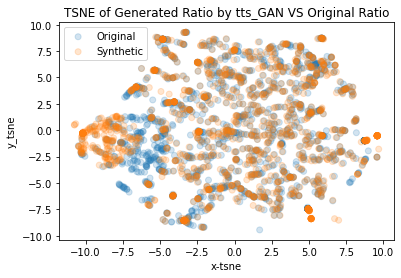

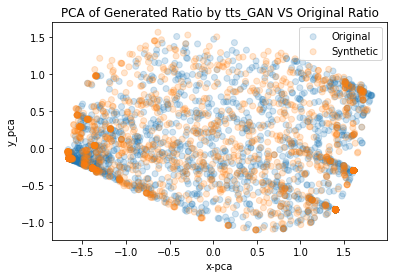

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3198 samples in 0.001s...
[t-SNE] Computed neighbors for 3198 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3198
[t-SNE] Computed conditional probabilities for sample 2000 / 3198
[t-SNE] Computed conditional probabilities for sample 3000 / 3198
[t-SNE] Computed conditional probabilities for sample 3198 / 3198
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.248329
[t-SNE] KL divergence after 300 iterations: 1.558119


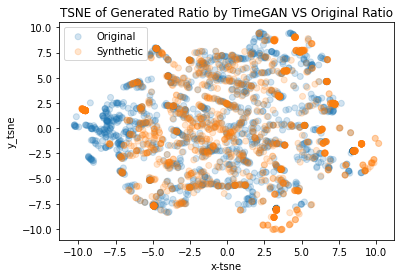

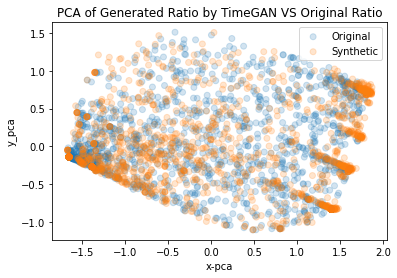

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3198 samples in 0.001s...
[t-SNE] Computed neighbors for 3198 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3198
[t-SNE] Computed conditional probabilities for sample 2000 / 3198
[t-SNE] Computed conditional probabilities for sample 3000 / 3198
[t-SNE] Computed conditional probabilities for sample 3198 / 3198
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.400932
[t-SNE] KL divergence after 300 iterations: 1.597431


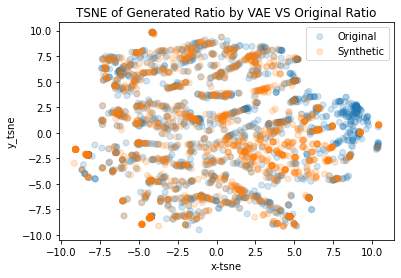

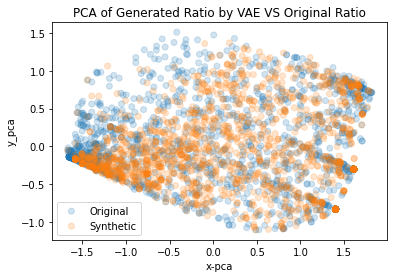

In [18]:
visualization(ori_data=np.expand_dims(real_tts,axis=2), 
              generated_data=np.expand_dims(fake_tts_mean,axis=2), 
              analysis="tsne",
              fig_title="Generated Ratio by tts_GAN VS Original Ratio",
              anal_sample_no=real_tts.shape[0])
visualization(ori_data=np.expand_dims(real_tts,axis=2), 
              generated_data=np.expand_dims(fake_tts_mean,axis=2), 
              analysis="pca",
              fig_title="Generated Ratio by tts_GAN VS Original Ratio",
              anal_sample_no=real_tts.shape[0])

visualization(ori_data=np.expand_dims(real_timegan,axis=2), 
              generated_data=np.expand_dims(fake_timegan_mean,axis=2), 
              analysis="tsne",
              fig_title="Generated Ratio by TimeGAN VS Original Ratio",
              anal_sample_no=real_timegan.shape[0])
visualization(ori_data=np.expand_dims(real_timegan,axis=2), 
              generated_data=np.expand_dims(fake_timegan_mean,axis=2), 
              analysis="pca",
              fig_title="Generated Ratio by TimeGAN VS Original Ratio",
              anal_sample_no=real_timegan.shape[0])

visualization(ori_data=np.expand_dims(real_vae,axis=2), 
              generated_data=np.expand_dims(fake_vae_mean,axis=2), 
              analysis="tsne",
              fig_title="Generated Ratio by VAE VS Original Ratio",
              anal_sample_no=real_vae.shape[0])
visualization(ori_data=np.expand_dims(real_vae,axis=2), 
              generated_data=np.expand_dims(fake_vae_mean,axis=2), 
              analysis="pca",
              fig_title="Generated Ratio by VAE VS Original Ratio",
              anal_sample_no=real_vae.shape[0])

In [ ]:
def cal_plot(real,fake,item):
    
    def get_CDF(data):##data：np.array数据类型

        data = data.reshape(1,-1)
        denominator = data.shape[1]#分母数量
        Data = pd.Series(data[0,:])
        #利用value_counts方法进行分组频数计算
        Fre = Data.value_counts()##每一个数出现的次数
        
        #对获得的表格整体按照索引自小到大进行排序
        Fre_sort=Fre.sort_index(axis=0,ascending=True)
        Fre_df=Fre_sort.reset_index()#将Series数据转换为DataFrame:column列名为“index”"0"
        ##column名称为index的列是所有GHI的数据，column名称为0的列是每一个GHI值出现的次数
        Fre_df[0]=Fre_df[0]/denominator#转换成概率
        Fre_df.columns=['Rds','Fre']
        Fre_df['cumsum']=np.cumsum(Fre_df['Fre'])

        return Fre_df['Rds'],Fre_df['cumsum']

    real_Rds,real_cumsum = get_CDF(real.flatten())
    fake_Rds,fake_cumsum = get_CDF(fake.flatten())
    fig = plt.figure(figsize=(4,2))
    ax1 = fig.add_subplot(1,1,1)
    line1, = ax1.plot(real_Rds,real_cumsum)
    line2, = ax1.plot(fake_Rds,fake_cumsum )
    ax1.legend([line1,line2], ['Real-cdf','Fake-cdf'])
    ax1.set_title("CDF")
    ax1.set_xlabel('{}'.format(str(item)))
    ax1.set_ylabel("CDF")

    plt.tight_layout()
    plt.show()


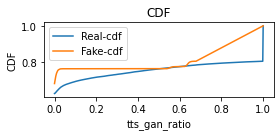

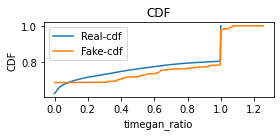

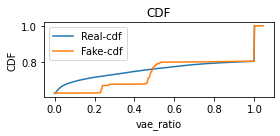

In [15]:
cal_plot(real=real_tts,fake= fake_tts_mean,item="tts_gan_ratio")
cal_plot(real=real_timegan,fake= fake_timegan_mean,item="timegan_ratio")
cal_plot(real=real_vae,fake= fake_vae_mean,item="vae_ratio")

In [19]:
def get_generated_ratio(data_path):##"/remote-home/21310019/2024/pv_TSTR/TS/fake_ratio/generated_data_2.npz"
    data_npz_gen = np.load(
        data_path
        )    
    generated_data_all = data_npz_gen["arr_0"]
    data_ratio = generated_data_all[:,:,0]
    #data_cp = generated_data_all[:,:,1]
    return data_ratio
ratio_my = []
for i in range(5): 
    ratio_my.append(get_generated_ratio(f"/remote-home/21310019/2024/pv_TSTR/TS/fake_ratio/generated_data_{i+1}.npz"))
gen_ratio = np.mean(np.stack(ratio_my),axis = 0)
gen_ratio.shape

(1617, 24)

In [20]:
from scipy.stats import gaussian_kde
from scipy.spatial.distance import euclidean
from scipy.special import rel_entr
#from scipy.spatial.distance import bhattacharyya

def get_kde(data1,data2,item,draw_pic_sig = None):
    
    def js_divergence(p, q):
        m = 0.5 * (p + q)
        return 0.5 * np.sum(rel_entr(p, m)) + 0.5 * np.sum(rel_entr(q, m))
    # 计算KDE
    kde1 = gaussian_kde(data1)
    kde2 = gaussian_kde(data2)

    # 绘制频率直方图和KDE拟合曲线
    x_grid = np.linspace(min(min(data1), min(data2)), max(max(data1), max(data2)), 1000)
    if draw_pic_sig is not None:
        plt.hist(data1, bins=30, density=True, alpha=0.5, color='blue',label="original")
        plt.hist(data2, bins=30, density=True, alpha=0.5, color='red',label="generated")
        plt.plot(x_grid, kde1(x_grid), color='blue')
        plt.plot(x_grid, kde2(x_grid), color='red')
        plt.legend()
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title(f'{item} KDE Fit to Histograms')
        plt.show()

    # 计算相似性（使用欧几里得距离作为示例）
    kde1_values = kde1(x_grid)
    kde2_values = kde2(x_grid)
    similarity = euclidean(kde1_values, kde2_values)
    # 确保值为正以避免 log 计算问题
    kde1_values += 1e-10
    kde2_values += 1e-10

    # 计算KL散度
    kl_divergence = np.sum(rel_entr(kde1_values, kde2_values))
    print("KL Divergence:", kl_divergence)
    js_divergence_1_2 = js_divergence(kde1_values, kde2_values)
    print("JS_Divergence:", js_divergence_1_2)
    # 计算Bhattacharyya距离
    bhattacharyya_dist = -np.log(np.sum(np.sqrt(kde1_values * kde2_values)))
    print("Bhattacharyya Distance:", bhattacharyya_dist)
    print("Similarity (Euclidean distance):", similarity)

    return similarity,kl_divergence,js_divergence_1_2,bhattacharyya_dist


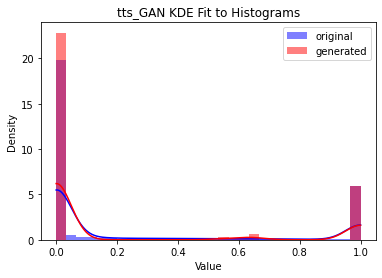

KL Divergence: 389.9677482804424
JS_Divergence: 22.283444130041687
Bhattacharyya Distance: -6.261183753543611
Similarity (Euclidean distance): 5.480060273559582


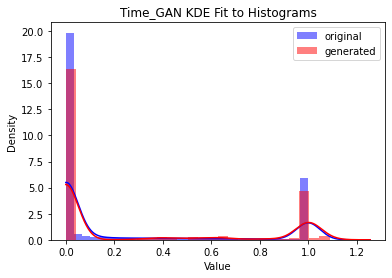

KL Divergence: 43.65868184432836
JS_Divergence: 6.259885919227536
Bhattacharyya Distance: -6.262832140740048
Similarity (Euclidean distance): 3.353592656009445


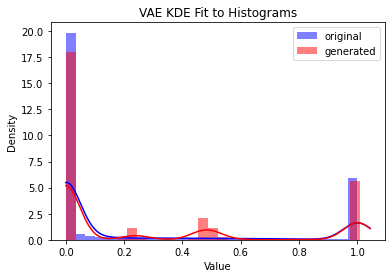

KL Divergence: 75.51113987535982
JS_Divergence: 23.55872508048536
Bhattacharyya Distance: -6.3854643004491605
Similarity (Euclidean distance): 8.892601200554946


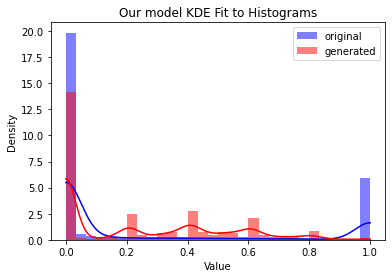

KL Divergence: 332.54539247311584
JS_Divergence: 116.67662227103762
Bhattacharyya Distance: -6.298629799807976
Similarity (Euclidean distance): 23.350578943115565


In [21]:
similarity_tts,kl_divergence_tts,js_tTS,bhattacharyya_dist_tts = get_kde(data1=real_tts.flatten(),                            
                                                                  data2=fake_tts_mean.flatten(),
                                                                  item="tts_GAN",
                                                                  draw_pic_sig=True)

similarity_timegan,kl_divergence_timegan,js_timegan,bhattacharyya_dist_timegan = get_kde(data1=real_timegan.flatten(),                            
                                                                  data2=fake_timegan_mean.flatten(),
                                                                  item="Time_GAN",
                                                                  draw_pic_sig=True)

similarity_vae,kl_divergence_vae,js_vae,bhattacharyya_dist_vae = get_kde(data1=real_vae.flatten(),                            
                                                                  data2=fake_vae_mean.flatten(),
                                                                  item="VAE",
                                                                  draw_pic_sig=True)

similarity_vae,kl_divergence_vae,js_vae,bhattacharyya_dist_vae = get_kde(data1=real_vae.flatten(),                            
                                                                  data2=gen_ratio.flatten(),
                                                                  item="Our model",
                                                                  draw_pic_sig=True)

In [25]:
import numpy as np
from scipy.spatial.distance import cdist

def gaussian_kernel(x, y, sigma=1.0):
    """Compute the Gaussian kernel between x and y"""
    dist = cdist(x, y, 'euclidean')
    return np.exp(-dist ** 2 / (2 * sigma ** 2))

def compute_mmd(x, y, kernel=gaussian_kernel, sigma=1.0):
    """Compute the MMD between two samples x and y"""
    K_xx = kernel(x, x, sigma)
    K_yy = kernel(y, y, sigma)
    K_xy = kernel(x, y, sigma)
    
    mmd = np.mean(K_xx) + np.mean(K_yy) - 2 * np.mean(K_xy)
    return mmd



# 计算 MMD
mmd_value_tts = compute_mmd(x=real_tts,y=fake_tts_mean, sigma=1.0)
print(f'MMD value: {mmd_value_tts}')
mmd_value_timegan = compute_mmd(x=real_timegan,y=fake_timegan_mean, sigma=1.0)
print(f'MMD value: {mmd_value_timegan}')
mmd_value_vae = compute_mmd(x=real_vae,y=fake_vae_mean, sigma=1.0)
print(f'MMD value: {mmd_value_vae}')
mmd_value_my = compute_mmd(x=real_vae,y=gen_ratio, sigma=1.0)
print(f'MMD value: {mmd_value_my}')


MMD value: 0.004891170352627261
MMD value: 0.009022552335181344
MMD value: 0.019824033581565537
MMD value: 0.28517823939647324
